# EduTrend Analytics: Predictive Insights and Pattern Detection in Academic Performance

## Short Backstory

This project originated from an assignment in my Artificial Intelligence class at Salem State University. Initially just another homework task, it quickly evolved into a project that captivated my interest far beyond the typical coding assignments encountered in other computing courses. The unique problem-solving approach required for this project sparked a deep engagement with the material.

## What is the project? 

For this assignment, our professor provided actual grade data from various programs at our college spanning several years. The data included a column with the program name and subsequent columns detailing the distribution of grades for each semester of each year. The project was notably open-ended: we were not given a specific question to answer with the data, allowing us full creative freedom to define our own inquiries. 

## The two questions I chose to answer with this data were 

 ### 1. Can the counts of A's, B's, and C's in a specific semester be used to predict the counts of D's and F's for a specific program using linear regression? 
   - This question initially began as "Can you predict the grade distribution for a certain semester using linear regression?" However, the only feature I was using initially was the year, which proved inadequate as it didn't offer enough predictive power. After discussing with my professor, I refined the question to focus on using the counts of higher grades (A's, B's, and C's) as predictors for the lower grades (D's and F's), which provided a more structured approach to understanding the impacts of academic achievement on subsequent lower performances. 
 ### 2. Can we cluster academic programs based on their grade distributions to identify similar academic performance patterns?
   - The aim of this question is to uncover and understand similarities or differences in grading patterns across various academic programs. By clustering programs based on how grades are distributed, you can identify groups of programs that share similar charecteristics in terms of student academic performace. 



# Import Libraries

In [347]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Data Exploration and Normalization 

### I wanted to produce a set of dataframes that mad sense and could be adapted for use with both questions.
* The data is not explained in grave detail here however both the original data and the manually altered data are available in the repo for visual inspection, this was also what I had done rather than doing it in code. 

### Fall Data
The first spreadsheet I approached was the the Fall data. To bring this sheet to a useable stat I created the method below which performs the following functions: 
- Drops the first column. This is because the first column is just empty. 
- This method also contains the ability to drop other columns specific to the sheet, for example different column configurations begin to get used in different years so I handle this in different ways which is explained as it is done below. 
- Some of the sheets have F* in the data, I interpreted this as some variation of an F so I combine the two in the data.
- As the data is a count of grades per semester in various programs, the empty cells implied no one had that grade so I populate the empty cells with 0 for later interpretation.
- This method then returns a dataframe of the data by sheet within the excel file.
- This method also combines the +- grades with the base grade. For example if there were 4 C's and 1 C- and a column the dataframe would have 5 dataframes, after this operation it drops the column. 

### Spring Data
As soon as I started with the spring I had decided that the best approach would be to generate the same dataframes as the Fall Data, these dataframes were already adapted by me for the use cases I had created them for. However I very quickly ran into problems, the spring spreadsheets were structured slightly different and had different names in some cases. I decided rather than building an overly complicated method and ripping my hair out over something that can be adapted for each, the best approach would be to just manually change the spreadsheets. The changes made here are reflected below and the original and manually altered data exist in this repo for reference, these changes are made in addition to the changes made to the fall data. 
- The individual sheet names in the Fall were named 2014-2023 for their respective years, I manually changed the Spring to reflect this. With the addition of 2024 in the Spring Data set since Spring 2024 was in progress upon receiving this data. 
- In the fall data all of the data typically started from box B2 , this was inconsistent in the Spring data so I manually dragged the entire data set to start from B2. 

### Summer Data 
By the time I got to the summer data, any problem I could have faced when it came to getting the data to the usable state I wanted I had already faced. A combination of the two from above was done in the process of getting to the summer dataframes. I had to do the exact manual changes I did to the spring data for a few sheets to make it able to pass into the method I created for the Fall Data. 



In [348]:
def process_sheet(df, drop_columns):
    """
    Process the sheet by dropping specified columns, combining grades if needed, and filling missing values.
    """
    # Drop the first column (Excel's 'Column A')
    df = df.drop(df.columns[0], axis=1) 
    
    # Drop other specified columns if they exist
    df = df.drop(columns=[col for col in drop_columns if col in df.columns], errors='ignore')
    
    # Combine 'F*' into 'F' if both columns exist
    if 'F*' in df.columns and 'F' in df.columns:
        df['F'] = df['F'].fillna(0) + df['F*'].fillna(0)
        df = df.drop(columns=['F*'])
    
       # Fill NaN values with zero and convert data types
    df = df.fillna(0)
    
    # Combine + and - grades with the base grade
    base_grades = ['A', 'B', 'C', 'D']
    for grade in base_grades:
        plus_grade = f'{grade}+'
        minus_grade = f'{grade}-'
        if plus_grade in df.columns and minus_grade in df.columns:
            df[grade] = df.get(grade, 0) + df.get(plus_grade, 0) + df.get(minus_grade, 0)
            df = df.drop(columns=[plus_grade, minus_grade])
        elif plus_grade in df.columns:
            df[grade] = df.get(grade, 0) + df.get(plus_grade, 0)
            df = df.drop(columns=[plus_grade])
        elif minus_grade in df.columns:
            df[grade] = df.get(grade, 0) + df.get(minus_grade, 0)
            df = df.drop(columns=[minus_grade])
   
    for col in df.columns[1:]:  # Start conversion from the second column
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
    
    return df

Here I drop the columns I will not be using the columns I decided to not use were P, W, (blank), I, NP, and MP. 

The reason I decided not to use these columns are as follows
 - P, W are outside the scope of only analyzing grades. Although they are people who took the class I think these situations are unique causing ireggularities. 
 - (blank) is extremely unclear and is seemingly useless data
 - I, NP, MP are not used in all of the sheets. I am going to narrow the data used in an attempt to answer the question to classes that exist in all years of the data so this makes no sense to keep. 

In [349]:
file_path_fall = 'Data/Fall2014-2023.xlsx' 
file_path_spring = 'Data/Spring2014-2024.xlsx'
file_path_summer = 'Data/Summer2014-2023.xlsx'


drop_columns = ['I', 'NP', 'MP', 'P', 'W', '(blank)']
processed_dataframes_fall = {}
processed_dataframes_spring = {}
processed_dataframes_summer = {}    

The following code pulls the data in for each year and calls the normilization method I created and discussed above for each of the three spreadsheets. 

##### Fall

In [350]:
for year in range(2014, 2024):
    sheet_name = str(year)
    df_year = pd.read_excel(file_path_fall, sheet_name=sheet_name, header=1)
      
    df_processed = process_sheet(df_year, drop_columns)
    
    # Store the processed dataframe in the dictionary
    processed_dataframes_fall[year] = df_processed
    print(f"Processed Year: {year}, Columns: {df_processed.columns.tolist()}")

Processed Year: 2014, Columns: ['Fall 2014', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2015, Columns: ['Fall 2015', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2016, Columns: ['Fall 2016', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2017, Columns: ['Fall 2017', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2018, Columns: ['Fall 2018', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2019, Columns: ['Fall 2019', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2020, Columns: ['Fall 2020', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2021, Columns: ['Fall 2021', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2022, Columns: ['Fall 2022', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2023, Columns: ['Fall 2023', 'A', 'B', 'C', 'D', 'F', 'Grand Total']


In [351]:
for year, df in processed_dataframes_fall.items():
    print(f"Year: {year}")
    print(df.head())
    print()

Year: 2014
    Fall 2014     A    B   C   D  F  Grand Total
0        UGRD  1667  511  94  11  3         3024
1   COMMGU-BS    49   20   9   1  0          102
2  CRIMJGU-BS   639  282  40   4  1         1278
3   EDEEGU-BS   215   22   4   1  0          328
4   EDELGU-BS   405  100  24   0  0          699

Year: 2015
    Fall 2015     A    B    C   D   F  Grand Total
0        GRAD    25   12    0   0   0           39
1  CRIMJGU-MS    25   12    0   0   0           39
2        UGRD  3314  918  165  20  33         5935
3    ARTGU-BA    40   10    0   0   0           62
4   COMMGU-BS    49   20    9   1   0          102

Year: 2016
    Fall 2016     A     B    C   D   F  Grand Total
0        GRAD    56    30    3   0   4          111
1  CRIMJGU-MS    49    30    3   0   4          100
2  ENGLGU-MAT     7     0    0   0   0           11
3        UGRD  4692  1211  224  34  58         8422
4    ARTGU-BA    58    20    9   1   3          123

Year: 2017
    Fall 2017     A     B    C   D   F  G

##### Spring

In [352]:
for year in range(2014, 2024):
    sheet_name = str(year)
    df_year = pd.read_excel(file_path_spring, sheet_name=sheet_name, header=1)
      
    df_processed = process_sheet(df_year, drop_columns)
    
    # Store the processed dataframe in the dictionary
    processed_dataframes_spring[year] = df_processed
    print(f"Processed Year: {year}, Columns: {df_processed.columns.tolist()}")

Processed Year: 2014, Columns: ['Spring 2014', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2015, Columns: ['Spring 2015', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2016, Columns: ['Spring 2016', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2017, Columns: ['Spring 2017', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2018, Columns: ['Spring 2018', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2019, Columns: ['Spring 2019', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2020, Columns: ['Spring 2020', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2021, Columns: ['Spring 2021', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2022, Columns: ['Spring 2022', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2023, Columns: ['Spring 2023', 'A', 'B', 'C', 'D', 'F', 'Grand Total']


In [353]:
for year, df in processed_dataframes_spring.items():
    print(f"Year: {year}")
    print(df.head())
    print()

Year: 2014
  Spring 2014    A    B   C  D  F  Grand Total
0        UGRD  595  241  42  4  1         1165
1        UDAS   86   23   9  1  0          147
2   COMMGU-BS   49   20   9  1  0          102
3  ENGLEGU-BA   37    3   0  0  0           45
4        UDHS  509  218  33  3  1         1018

Year: 2015
  Spring 2015     A    B    C   D  F  Grand Total
0        UGRD  1783  540  101  12  3         3223
1   COMMGU-BS    49   20    9   1  0          102
2  CRIMJGU-BS   665  290   42   4  1         1321
3   EDEEGU-BS   253   23    4   1  0          387
4   EDELGU-BS   428  111   26   0  0          746

Year: 2016
  Spring 2016     A    B    C   D   F  Grand Total
0        GRAD    25   12    0   0   0           39
1  CRIMJGU-MS    25   12    0   0   0           39
2        UGRD  3451  930  172  20  33         6145
3    ARTGU-BA    40   10    0   0   0           62
4   COMMGU-BS    49   20    9   1   0          102

Year: 2017
  Spring 2017     A     B    C   D   F  Grand Total
0        GRAD

##### Summer

In [354]:
for year in range(2014, 2024):
    sheet_name = str(year)
    df_year = pd.read_excel(file_path_summer, sheet_name=sheet_name, header=1)
      
    df_processed = process_sheet(df_year, drop_columns)
    
    # Store the processed dataframe in the dictionary
    processed_dataframes_summer[year] = df_processed
    print(f"Processed Year: {year}, Columns: {df_processed.columns.tolist()}")

Processed Year: 2014, Columns: ['Summer 2014', 'A', 'B', 'C', 'D', 'F', 'Grand Total']


Processed Year: 2015, Columns: ['Summer 2015', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2016, Columns: ['Summer 2016', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2017, Columns: ['Summer 2017', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2018, Columns: ['Summer 2018', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2019, Columns: ['Summer 2019', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2020, Columns: ['Summer 2020', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2021, Columns: ['Summer 2021', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2022, Columns: ['Summer 2022', 'A', 'B', 'C', 'D', 'F', 'Grand Total']
Processed Year: 2023, Columns: ['Summer 2023', 'A', 'B', 'C', 'D', 'F', 'Grand Total']


In [355]:
for year, df in processed_dataframes_summer.items():
    print(f"Year: {year}")
    print(df.head())
    print()

Year: 2014
  Summer 2014    A    B   C  D  F  Grand Total
0        UGRD  595  241  42  4  1         1165
1   COMMGU-BS   49   20   9  1  0          102
2  CRIMJGU-BS  438  196  29  3  1          876
3   EDELGU-BS   71   22   4  0  0          142
4  ENGLEGU-BA   37    3   0  0  0           45

Year: 2015
  Summer 2015     A    B    C   D  F  Grand Total
0        GRAD    22    9    0   0  0           31
1  CRIMJGU-MS    22    9    0   0  0           31
2        UGRD  1719  528  100  13  3         3132
3   COMMGU-BS    49   20    9   1  0          102
4  CRIMJGU-BS   581  262   37   3  1         1170

Year: 2016
  Summer 2016     A    B    C   D   F  Grand Total
0        GRAD    62   26    2   0   4          107
1  CRIMJGU-MS    62   26    2   0   4          107
2        UGRD  3227  862  164  15  32         5714
3    ARTGU-BA    40   10    0   0   0           62
4   COMMGU-BS    49   20    9   1   0          102

Year: 2017
  Summer 2017     A     B    C   D   F  Grand Total
0        GRAD

### Deciding what Data to use
With the data now processed to the desired state, I aimed to narrow the scope of analysis to enhance the relevance to my research question. To achieve this, I focused on the most consistently available data across all years within the given dataframes. Below, I created a method that leverages Python's set intersection to identify programs that were consistently offered throughout all the years covered by the dataframes. This approach helps ensure that the analysis is based on comprehensive and stable data, reducing variability caused by transient or infrequently offered programs.

In [356]:
def analyze_program_presence(processed_dataframes):
    # Initialize a dictionary to store sets of programs for each year
    program_sets = {}

    # Iterate over each year's DataFrame to collect program names
    for year, df in processed_dataframes.items():
        program_column = df.columns[0] 
        programs = set(df[program_column].unique())
        program_sets[year] = programs

    # Find programs that exist in all years using set intersection
    common_programs = set.intersection(*program_sets.values())

    # Find programs that are unique to each year using set difference
    unique_programs = {year: program_sets[year] - common_programs for year in program_sets}

    return common_programs, unique_programs

In [357]:
common_programs, unique_programs = analyze_program_presence(processed_dataframes_fall)

print("Programs that exist in all years:")
print(common_programs)

Programs that exist in all years:
{'CRIMJGU-BS', 'HISTGU-BA', 'MATHGU-BS', 'EDEEGU-BS', 'ENGGU-BA', 'Grand Total', 'EDELGU-BS', 'UGRD'}


In [358]:
common_programs, unique_programs = analyze_program_presence(processed_dataframes_spring)

print("Programs that exist in all years:")
print(common_programs)

Programs that exist in all years:
{'CRIMJGU-BS', 'ENGLEGU-BA', 'Grand Total', 'EDELGU-BS', 'UGRD'}


In [359]:
common_programs, unique_programs = analyze_program_presence(processed_dataframes_summer)

print("Programs that exist in all years:")
print(common_programs)

Programs that exist in all years:
{'CRIMJGU-BS', 'ENGLEGU-BA', 'Grand Total', 'EDELGU-BS', 'UGRD'}


# 1. Can the counts of A's, B's, and C's in a specific semester be used to predict the counts of D's and F's for a specific program using linear regression?

As specified in the beginning this question was one of the questions I chose for the purpose of the assignment but found myself enjoying the process of answering. This question focuses on utilizing counts of higher grades (A's, B's, and C's) within a specific semester to predict the occurences of lower grades (D's and F's) using a linear regression model. Initially this question was aimed to predict the overall grade distributions using only the year as a predictor, which was an insufficient solution. After revising the approach based on feedback, the refined question aims to explore how well the performance in hgiher grades can serve as an indicator for lower grade outcomes. This should offer a targeted analysis of academic performance trends over time. 

### Graph Method 
- Below is a graph that visualizes the distribution of grades for a certain program that you call the method on, for the purpose of not bloating this notebook I only did one common program from each of the three sheets. However I still think this is a nice visualization. 

In [360]:
def plot_grade_distributions(processed_dataframes, program_name):
    grade_columns = ['A', 'B', 'C', 'D', 'F']
    years = sorted(processed_dataframes.keys())
    grades_data = {grade: [0]*len(years) for grade in grade_columns}

    for idx, year in enumerate(years):
        df = processed_dataframes[year]
        if program_name in df.iloc[:, 0].values:
            program_data = df[df.iloc[:, 0] == program_name]
            for grade in grade_columns:
                if grade in program_data.columns:
                    grades_data[grade][idx] = program_data[grade].values[0]

    plt.figure(figsize=(12, 8))
    for grade in grade_columns:
        plt.plot(years, grades_data[grade], marker='o', label=grade)

    plt.title(f'Grade Distribution per Year for {program_name}')
    plt.xlabel('Year')
    plt.ylabel('Number of Grades')
    plt.xticks(years)
    plt.legend(title='Grade')
    plt.grid(True)
    plt.show()

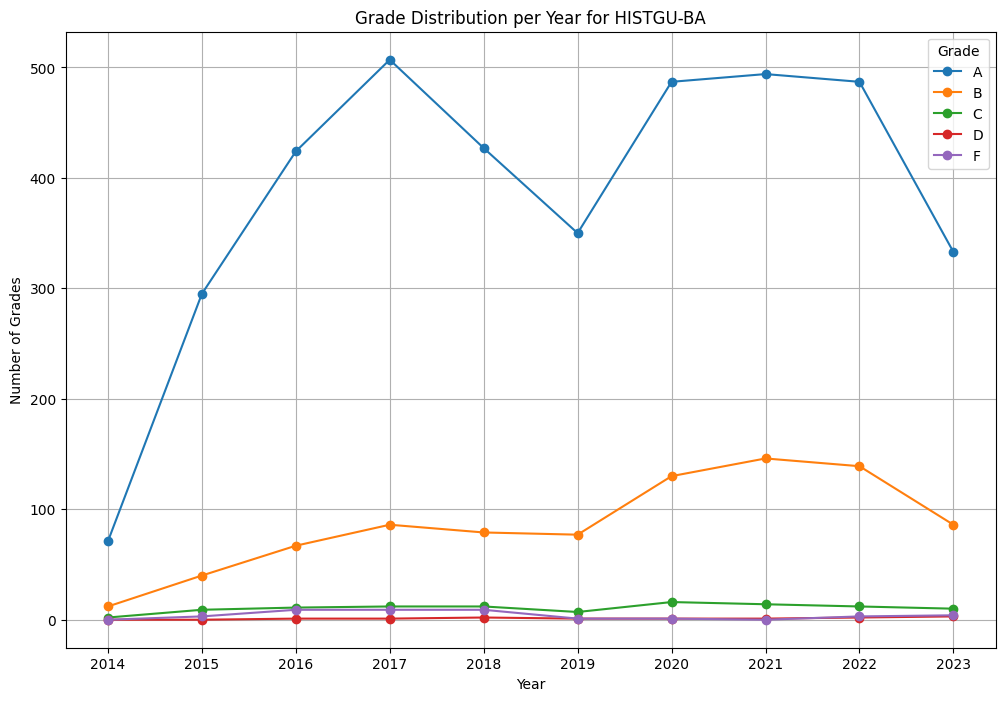

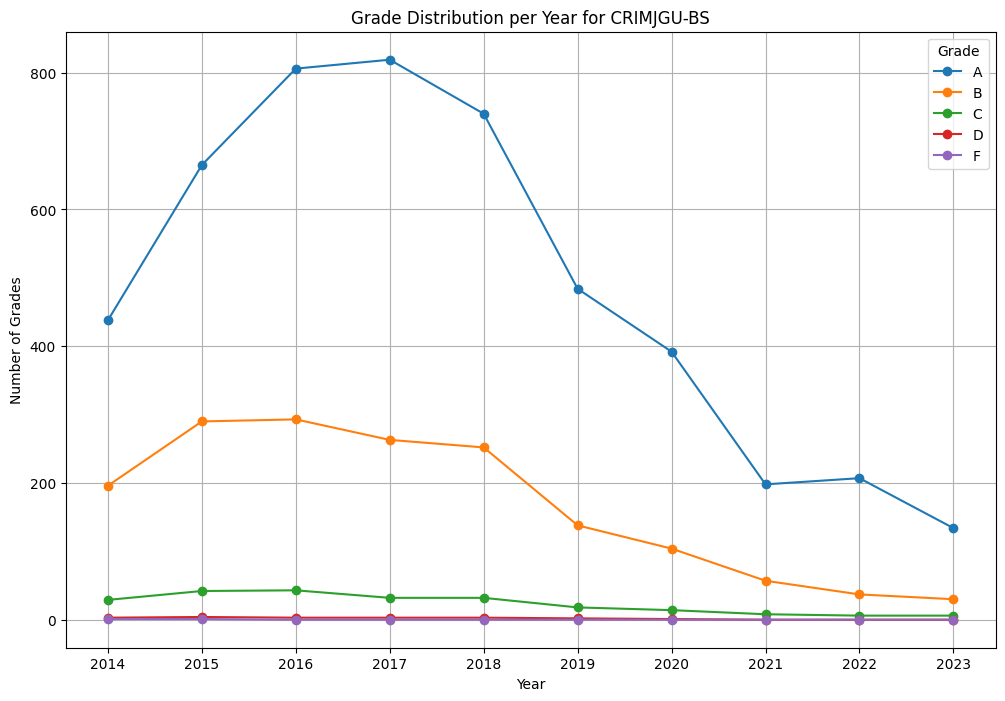

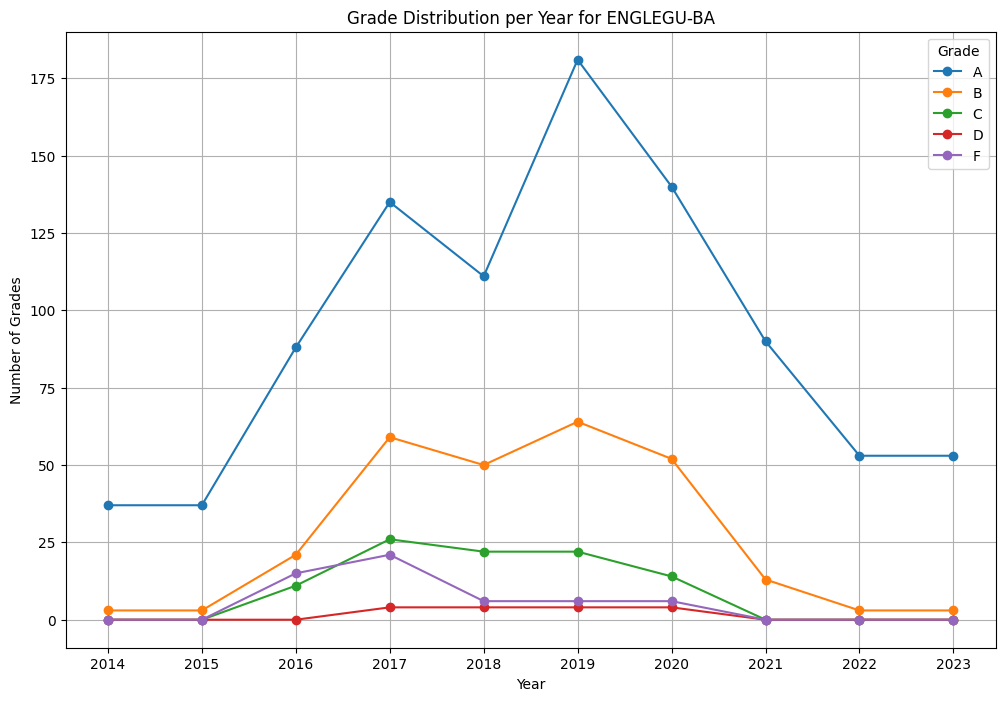

In [361]:
plot_grade_distributions(processed_dataframes_fall, 'HISTGU-BA')

plot_grade_distributions(processed_dataframes_spring, 'CRIMJGU-BS')

plot_grade_distributions(processed_dataframes_spring, 'ENGLEGU-BA')

## Linear Regression Model
- The following cells are the building of the linear regression model. 

Here we define the feature and target grade, as stated above we are trying to use the count of A's, B's and C's to predict the count of D's and F's. So below we define these as the feature and target grades respectively. Then wew define the prediction and training years, as the data is very limited I wanted as much training data as possible so I use all the years but one for the training data and predict on the last year. 

In [362]:
# Define feature and target grades
feature_grades = ['A', 'B', 'C'] 
target_grades = ['D', 'F']        

# Define the training and prediction years
end_train_year = 2022  
prediction_year = 2023 

This method I created for the purpose of extracting the structure data into the feature grades (x) and the target grades (y) for training the machine learning model. 

In [363]:
def prepare_data_for_model(processed_dataframes, program_name, feature_grades, target_grades, start_year, end_year):
    X, y = [], []
    for year in range(start_year, end_year + 1):
        df = processed_dataframes.get(year)
        if df is not None and program_name in df.iloc[:, 0].values:
            program_data = df[df.iloc[:, 0] == program_name].iloc[0]
            X.append([program_data.get(grade, 0) for grade in feature_grades])
            y.append([program_data.get(grade, 0) for grade in target_grades])
    return np.array(X), np.array(y)

The predict_grades_for_programs method is designed to predict grades 

In [364]:
def predict_grades_for_programs(processed_dataframes, common_programs, feature_grades, target_grades, end_train_year, prediction_year):
    results = {}
    model = LinearRegression()

    for program_name in common_programs:
        X_train, y_train = prepare_data_for_model(processed_dataframes, program_name, feature_grades, target_grades, 2014, end_train_year)
        X_test, y_test = prepare_data_for_model(processed_dataframes, program_name, feature_grades, target_grades, prediction_year, prediction_year)

        if X_train.size > 0 and y_train.size > 0:
            model.fit(X_train, y_train)
            if X_test.size > 0:
                predicted_grades = model.predict(X_test)
                predicted_grades = predicted_grades.flatten()  # Ensure it matches y_test dimensions
                actual_grades = y_test.flatten()

            else:
                predicted_grades = np.zeros(len(target_grades))
                actual_grades = np.zeros(len(target_grades))
                mse = mae = r2 = None  # No test data available

            results[program_name] = {
                'Training Data': X_train,
                'Training Targets': y_train,
                'Predicted Grades': pd.DataFrame({
                    'Grade': target_grades,
                    'Predicted Count': predicted_grades,
                    'Actual Count': actual_grades
                }),
            }
        else:
            print(f"No data available to train for {program_name}.")

    return results


#### Fall

In [365]:
predictions = predict_grades_for_programs(processed_dataframes_fall, common_programs, feature_grades, target_grades, end_train_year, prediction_year)

for program_name, result in predictions.items():
    print(f"\nResults for {program_name} in {prediction_year}:")
    print("Predicted vs. Actual Grades:")
    print(result['Predicted Grades'])



Results for CRIMJGU-BS in 2023:
Predicted vs. Actual Grades:
  Grade  Predicted Count  Actual Count
0     D         0.562727             0
1     F         0.258899             0

Results for ENGLEGU-BA in 2023:
Predicted vs. Actual Grades:
  Grade  Predicted Count  Actual Count
0     D              0.0           0.0
1     F              0.0           0.0

Results for Grand Total in 2023:
Predicted vs. Actual Grades:
  Grade  Predicted Count  Actual Count
0     D        17.729342            26
1     F        50.788444            38

Results for EDELGU-BS in 2023:
Predicted vs. Actual Grades:
  Grade  Predicted Count  Actual Count
0     D         1.377874             4
1     F         7.341901            11

Results for UGRD in 2023:
Predicted vs. Actual Grades:
  Grade  Predicted Count  Actual Count
0     D        17.572709            26
1     F        48.014145            33


#### Spring

In [366]:
predictions = predict_grades_for_programs(processed_dataframes_spring, common_programs, feature_grades, target_grades, end_train_year, prediction_year)

for program_name, result in predictions.items():
    print(f"\nResults for {program_name} in {prediction_year}:")
    print("Predicted vs. Actual Grades:")
    print(result['Predicted Grades'])


Results for CRIMJGU-BS in 2023:
Predicted vs. Actual Grades:
  Grade  Predicted Count  Actual Count
0     D         0.084340             0
1     F         0.194159             0

Results for ENGLEGU-BA in 2023:
Predicted vs. Actual Grades:
  Grade  Predicted Count  Actual Count
0     D        -0.499824             0
1     F         2.043574             0

Results for Grand Total in 2023:
Predicted vs. Actual Grades:
  Grade  Predicted Count  Actual Count
0     D        27.810971            27
1     F        50.415587            39

Results for EDELGU-BS in 2023:
Predicted vs. Actual Grades:
  Grade  Predicted Count  Actual Count
0     D         2.808188             5
1     F        13.066966            11

Results for UGRD in 2023:
Predicted vs. Actual Grades:
  Grade  Predicted Count  Actual Count
0     D        27.264515            27
1     F        47.239519            35


#### Summer

In [367]:
predictions = predict_grades_for_programs(processed_dataframes_summer, common_programs, feature_grades, target_grades, end_train_year, prediction_year)

for program_name, result in predictions.items():
    print(f"\nResults for {program_name} in {prediction_year}:")
    print("Predicted vs. Actual Grades:")
    print(result['Predicted Grades'])


Results for CRIMJGU-BS in 2023:
Predicted vs. Actual Grades:
  Grade  Predicted Count  Actual Count
0     D         0.197069             0
1     F         0.227892             0

Results for ENGLEGU-BA in 2023:
Predicted vs. Actual Grades:
  Grade  Predicted Count  Actual Count
0     D         0.472181             0
1     F        -2.959421             0

Results for Grand Total in 2023:
Predicted vs. Actual Grades:
  Grade  Predicted Count  Actual Count
0     D        16.822365            22
1     F        50.199933            35

Results for EDELGU-BS in 2023:
Predicted vs. Actual Grades:
  Grade  Predicted Count  Actual Count
0     D         1.658358             4
1     F         8.726368            12

Results for UGRD in 2023:
Predicted vs. Actual Grades:
  Grade  Predicted Count  Actual Count
0     D        16.719989            22
1     F        47.724565            30


# 2. Can we cluster academic programs based on their grade distributions to identify similar academic performance patterns?

As specified in the beginning. Here we are going to use Kmeans clustering to attempt to cluster the academic programs based on the grade distributions to easily identify ones with similar performace patterns across years. 

## Prep the data

Here the objective was to combine all the data from multiple years into a single dataframe to facilitate the clustering. 

Each row in the Dataframe represents a the grade distribution of a particular program in a specific year. This method takes the program name and combines it with the year it is as seen when the head is previewed below, that way that are treated seperately if they have the same program name. Then the grade distribution is collected for each program and year. Forming the features that will be used for clustering. 

In [368]:
def prepare_clustering_data(processed_dataframes):
    data = []
    program_labels = []
    
    # Loop through each year's data
    for year, df in processed_dataframes.items():
        for index, row in df.iterrows():
            # Create a unique label for each program-year combination
            program_labels.append(f"{row.iloc[0]}-{year}")
            # Collect grades for clustering
            data.append([row[grade] for grade in ['A', 'B', 'C', 'D', 'F']])
    
    return pd.DataFrame(data, index=program_labels, columns=['A', 'B', 'C', 'D', 'F'])

# Prepare the data
df_clustering_fall = prepare_clustering_data(processed_dataframes_fall)
print('Fall')
print(df_clustering_fall.head())
print('')

df_clustering_spring = prepare_clustering_data(processed_dataframes_spring)
print('Spring')
print(df_clustering_spring.head())
print('')

df_clustering_summer = prepare_clustering_data(processed_dataframes_summer)
print('Summer')
print(df_clustering_summer.head())
print('')


Fall
                    A    B   C   D  F
UGRD-2014        1667  511  94  11  3
COMMGU-BS-2014     49   20   9   1  0
CRIMJGU-BS-2014   639  282  40   4  1
EDEEGU-BS-2014    215   22   4   1  0
EDELGU-BS-2014    405  100  24   0  0

Spring
                   A    B   C  D  F
UGRD-2014        595  241  42  4  1
UDAS-2014         86   23   9  1  0
COMMGU-BS-2014    49   20   9  1  0
ENGLEGU-BA-2014   37    3   0  0  0
UDHS-2014        509  218  33  3  1

Summer
                   A    B   C  D  F
UGRD-2014        595  241  42  4  1
COMMGU-BS-2014    49   20   9  1  0
CRIMJGU-BS-2014  438  196  29  3  1
EDELGU-BS-2014    71   22   4  0  0
ENGLEGU-BA-2014   37    3   0  0  0



## Standarize the Features

Here we are normalizing the grade data to ensure that each feature contributes equally to the analysis.

K-means clustering performs best when all geatures are on a similar scale. If one grade typically has higher numbers it could disproportionately influence the cluster assignments. The tool we utilize from scikit-learn standadizes features by removing the mean and scaling to unit variance. The standardization transforms the data so that its distribution will have a mean value of 0 and standard deviation of 1. 

In [369]:
scaler = StandardScaler()

data_scaled_fall = scaler.fit_transform(df_clustering_fall)
print('Fall')
print(pd.DataFrame(data_scaled_fall, columns=df_clustering_fall.columns).head())
print('')

data_scaled_spring = scaler.fit_transform(df_clustering_spring)
print('Spring')
print(pd.DataFrame(data_scaled_spring, columns=df_clustering_spring.columns).head())
print('')

data_scaled_summer = scaler.fit_transform(df_clustering_summer)
print('Summer')
print(pd.DataFrame(data_scaled_summer, columns=df_clustering_summer.columns).head())
print('')


Fall
          A         B         C         D         F
0  0.789344  1.060193  1.084271  0.754909 -0.234918
1 -0.395391 -0.378196 -0.293073 -0.315978 -0.443258
2  0.036620  0.389335  0.209252  0.005288 -0.373811
3 -0.273842 -0.372337 -0.374093 -0.315978 -0.443258
4 -0.134720 -0.143835 -0.050012 -0.423067 -0.443258

Spring
          A         B         C         D         F
0 -0.020911  0.241302  0.226466  0.005265 -0.355602
1 -0.379307 -0.382097 -0.303310 -0.317829 -0.430238
2 -0.405359 -0.390676 -0.303310 -0.317829 -0.430238
3 -0.413809 -0.439289 -0.447794 -0.425527 -0.430238
4 -0.081465  0.175530  0.081981 -0.102433 -0.355602

Summer
          A         B         C         D         F
0  0.104987  0.420219  0.377538  0.099949 -0.350357
1 -0.400897 -0.380340 -0.274357 -0.295143 -0.437752
2 -0.040478  0.257209  0.120731 -0.031748 -0.350357
3 -0.380513 -0.373095 -0.373129 -0.426841 -0.437752
4 -0.412015 -0.441921 -0.452146 -0.426841 -0.437752



## Determine the Optimal Number of Clusters

Here we are using the elbow method to find a suitable number of clusters.

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

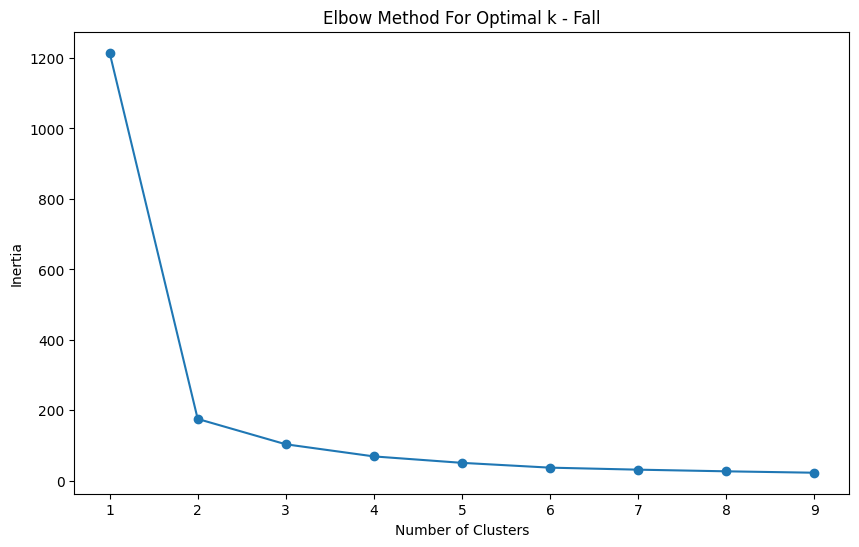

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

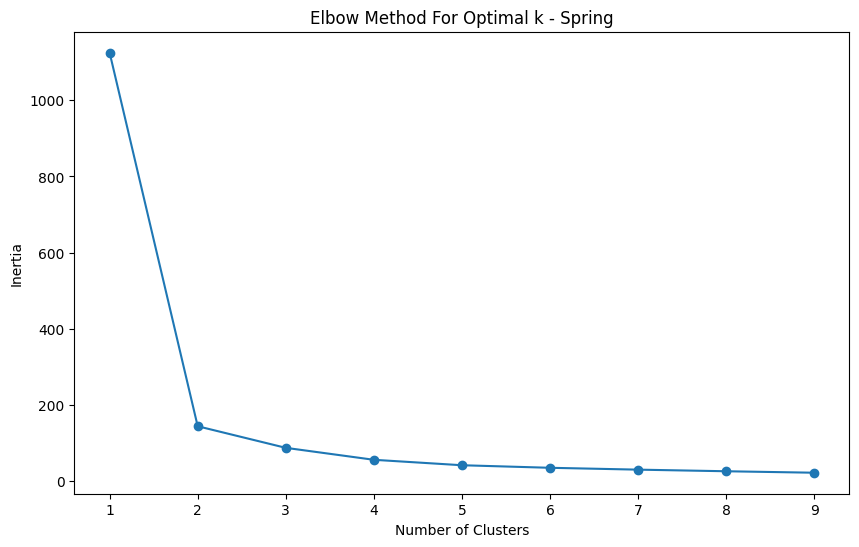

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

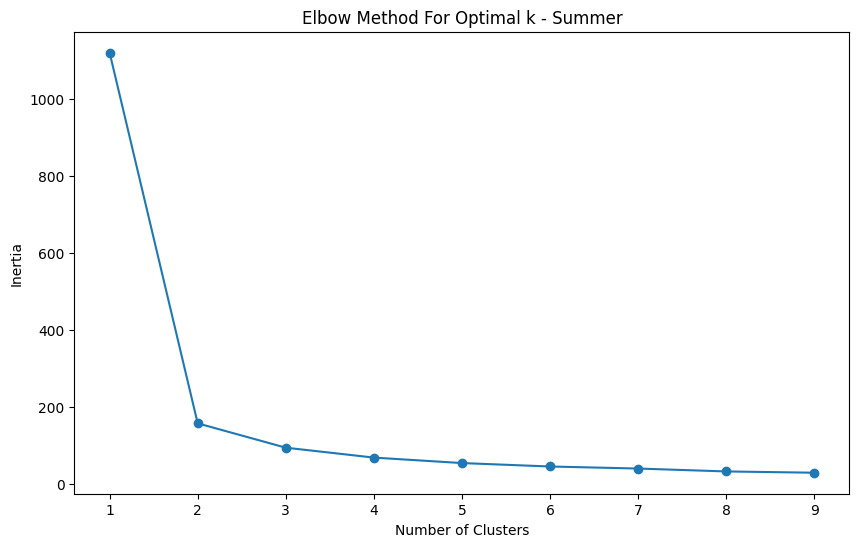

In [370]:
def plot_elbow_graph(data_scaled, season):
    inertia = []
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data_scaled)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 10), inertia, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title(f'Elbow Method For Optimal k - {season}')
    plt.show()

plot_elbow_graph(data_scaled_fall, "Fall")
plot_elbow_graph(data_scaled_spring, "Spring")
plot_elbow_graph(data_scaled_summer, "Summer")

In [371]:
def calculate_and_print_cluster_means(data_scaled, original_df, season):
    # Choose an optimal k based on your previous analysis, e.g., k=2 or as determined by the elbow method
    optimal_k = 2
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    clusters = kmeans.fit_predict(data_scaled)
    
    # Add the cluster information back to the original DataFrame
    original_df['Cluster'] = clusters
    
    # Calculate mean grades for each cluster
    cluster_means = original_df.groupby('Cluster').mean()
    
    # Print the result
    print(f'{season} - Cluster Means:')
    print(cluster_means)
    print('\n')  

# Call the function for each dataset
calculate_and_print_cluster_means(data_scaled_fall, df_clustering_fall, "Fall")
calculate_and_print_cluster_means(data_scaled_spring, df_clustering_spring, "Spring")
calculate_and_print_cluster_means(data_scaled_summer, df_clustering_summer, "Summer")

Fall - Cluster Means:
                   A            B           C          D          F
Cluster                                                            
0         235.106667    59.391111   10.680000   1.520000   2.640000
1        5012.500000  1270.444444  232.166667  34.333333  53.166667


Spring - Cluster Means:
                  A            B           C          D          F
Cluster                                                           
0         257.08134    65.588517   11.598086   1.583732   2.334928
1        5426.68750  1345.687500  240.750000  34.875000  50.562500


Summer - Cluster Means:
                   A            B           C          D          F
Cluster                                                            
0         202.293269    53.432692    9.653846   1.326923   2.110577
1        4113.812500  1055.312500  194.937500  28.125000  42.687500




/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
